In [ ]:
# ! pip install gym
# ! pip install pygame
# ! pip install mockseries --user

In [11]:
import torch
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete, Tuple
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\Users\\20175862\\Documents\\MscArtificialIntelligence\\Project RL\\Project\\Project-of-RL\\temp'

In [3]:
df_train_data = pd.read_excel('../../train.xlsx', index_col=0)
df_train_data = df_train_data.reset_index(drop=True)
# train_data = df_train_data.drop(columns=['PRICES'])
# train_data.columns = [i for i in range(24)]
# train_data = train_data.dropna()
# price_quantiles = np.quantile(train_data, [0.25, 0.5, 0.75])

# c = pd.cut(
#     train_data.stack(),
#     [-np.inf] + list(price_quantiles) + [np.inf],
#     labels=[0, 1, 2, 3]
# )
# prices = train_data.join(c.unstack().add_suffix('_cat'))
# episodic_prices = price_discretized.iloc[:, 24:].copy()
# prices = price_discretized.iloc[:, :24].copy()

In [4]:
df_train_data

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,15.00,10.00,8.17,27.77,37.99,33.11,37.99,33.00,36.48,30.65
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,37.57,36.45,37.99,53.00,59.69,50.09,50.00,36.22,31.09,29.84
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,43.21,43.99,48.00,57.00,60.99,55.51,51.77,34.51,39.31,38.05
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,40.01,38.00,42.66,53.00,58.99,53.50,44.01,35.00,34.46,31.57
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,40.06,38.00,38.61,49.84,53.00,45.91,36.74,29.61,30.61,27.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,27.99,21.00,14.00,5.00,0.01,0.01,0.01,0.01,0.01,18.00,...,25.00,19.11,17.69,34.99,44.43,44.50,44.00,36.32,39.93,32.00
1092,19.04,20.55,20.00,11.94,9.99,13.31,18.31,29.52,35.77,41.00,...,38.03,37.00,39.63,55.29,56.18,45.88,41.30,36.44,38.20,34.00
1093,28.50,25.55,22.86,17.00,16.58,19.78,26.91,33.90,34.89,37.10,...,34.87,29.01,28.41,42.30,47.45,43.62,38.62,31.27,35.00,30.08
1094,21.21,16.73,12.66,9.50,9.04,9.78,16.30,24.36,34.00,38.01,...,38.41,32.00,33.37,44.99,48.00,42.00,34.01,28.18,33.00,27.99


In [27]:
# fix something here maybe in order to have it so that action is adjusted in step function to closest action that is allowed at 7am,
# and so that the action does not result in negative battery level

def get_legal_actions_at_last(all_actions, current_level, min_level=2):
    '''
    Expected behavior: [-2,-1,0,1,2], currently 0 -> [2]
    Expected behavior: [-2,-1,0,1,2], currently 1 -> [1,2]
    Expected behavior: [-2,-1,0,1,2], currently 2 -> [0,1,2]
    Expected behavior: [-2,-1,0,1,2], currently 3 -> [-1,0,1,2]
    Expected behavior: [-2,-1,0,1,2], currently 4 -> [-2,-1,0,1,2]
    '''
    all_actions = np.asarray(all_actions)
    charge_needed = min_level - current_level
    avail_actions = all_actions[np.where(all_actions >= charge_needed)]
    # avail_actions = all_actions[list(np.where(all_actions >= charge_needed)[0])]
    return avail_actions.tolist()

def get_legal_actions(all_actions, current_level, min_level=0):
    all_actions = np.asarray(all_actions)
    underlying_levels = all_actions + current_level
    # avail_actions = all_actions[list(np.where(underlying_levels >= 0)[0])]
    avail_actions = all_actions[np.where(underlying_levels >= min_level)]
    return avail_actions.tolist()


def get_legal_range(full_range, current_level, min_level=20):
    '''
    Expected behavior: [-25,25], currently 0 -> [20,25]
    Expected behavior: [-25,25], currently 10 -> [10,25]
    Expected behavior: [-25,25], currently 20-> [0,25]
    Expected behavior: [-25,25], currently 30-> [-10,25]
    Expected behavior: [-25,25], currently 40 -> [-20,25]
    Expected behavior: [-25,25], currently 50 -> [-25,25]
    '''
    full_range = np.asarray(full_range)
    charge_needed = min_level - current_level
    avail_actions = [charge_needed, 25]
    return avail_actions

In [31]:
# 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# 2 take at_home out of the state *
# 3 include the action mechanics inside of the step function *
# 4 test environment again on random policy loop *
# 5 try q learning
# 6 change action to -1, 1 range *
# 7 change reward calculation *
# 8 test with the test environment (validate using main.py)
# 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# 10 change hour from 08-07 to 01-00 *

### contuinuous action mechanism:
# action comes in in continuous form in training loop, is modified in the step function in continuous form within range [-1,1], which
# is used then to update state variables, i.e. battery level, into a continuous variable between [0,50]
# state is returned in continuous form
# in tabular Q learning, state (from env.step) is taken and discretized to get next action
# in approximator methods, state is taken as continuous and used to get next action

class StorageEnv(Env):
    def __init__(self, path_to_train_data):
        '''
        Initialization of the energy storage environment;
        We interpret a run through all historical price data as one trajectory = one episode,
        where for each hour of each day, we can run the step function to update from one state
        to the next, given some action for that hour (the step function will return the next
        state, as well as next reward, and whether the entire historical dataset has been
        iterated through using the 'done' variable in the return statement).
        '''

        self.train_data = pd.read_excel(path_to_train_data)
        self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.train_data['PRICES']
        self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx

        self.battery_range =  Box(low=0, high=50, shape=(1,), dtype=np.float32)
        self.hour_range = Discrete(24, start=1)

        # obv space: battery level from 0 to 50 (continuous), hour of the dayt
        self.observation_space = Tuple((self.battery_range, self.hour_range))

        self.action_space = Discrete(5, start=-2)
        self.cont_action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # self.action_repr = [-2,-1,0,1,2]

        self.position_space = Discrete(2, start=0)

        self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
        
        self.counter = 0
        self.hour = 1
        self.day = 1
        self.num_hours_day = 24

        self.min_battery_level_start = 20
        self.min_battery_level = 0
        self.max_battery_level = 50
        self.max_charging_level = 25

        # initialize state vars
        self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level) # continuous value between 20 and 50
        # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
        self.at_home = np.random.randint(self.position_space.n) # 50% chance at home at start of each day
        # initial state
        self.state = [self.battery_level, self.hour]


    def step(self, action): # action is between -1 and 1
        ######### at current timestep t
        ### battery comsumption at timestep t

        # if it is 8am, decide whether car will go away or stay (by random chance)
        if self.hour == 8:
           self.at_home = np.random.randint(self.position_space.n)

        # convert action [-1,1] to actual kwh charging (transform to [-25,25])
        action = action * self.max_charging_level # now action lies in [-25,25]

        # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
        if not self.at_home: # check if car is currently away, enforced by overriding previous if statement
          action = 0

        # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
        elif self.at_home:
          # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
          if self.hour == 7: # adapt legal action calculating functions
            legal_actions = get_legal_range([self.cont_action_space.low[0], self.cont_action_space.high[0]], self.battery_level, min_level=20)
            if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures 20kwh of battery at 7am
              action = legal_actions[0] # charge needed for 20kwh, if initial action would result in <20 charge
          # rest of the day, ensure that battery stays above or at 0kwh
          else:
            legal_actions = get_legal_range([self.cont_action_space.low[0], self.cont_action_space.high[0]], self.battery_level, min_level=0)
            if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures >=0kwh of battery at 7am
              action = legal_actions[0] # charge needed to have positive >=0kwh charge, if initial action would result in negative <0kwh

        # removing 20kwh from battery when going away from home
        if not self.at_home:
          self.battery_level = self.battery_level - 20 if self.hour == 8 else self.battery_level

        # update battery level based on the picked acion at timestep t
        if self.at_home:
            self.battery_level += action

        # no over-charging above 50kwh
        if self.battery_level >= 50:
            self.battery_level = 50

        # should we move the constraints not lower 0 here ??

        ######### update the state for next hour, timestep t+1
        # keep the hour 8 ~ 18 same, otherwise athome = True
        self.at_home = self.at_home if 8 <= self.hour < 18 else 1 # TO-DO: check if this should not be <= 18 instead

        # reward calculations
        hourly_price = self.price_values[self.day-1][self.hour-1]
        cost_factor = 1.0 if action < 0 else 2.0
        efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

        # get amount of kwh bought during this step
        kwhs_charged = action # just for reading clarity
        price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
        # reward, based on current price from table
        reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

        # update counter and time variables
        self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
        self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

        if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
            self.hour = 1 # reset hour of the day for next timestep
            self.day += 1 # increment to start of next day

        # update state
        self.state = [self.battery_level, self.hour]

        # check if all hours in the dataset have been seen
        self.done = self.counter+1 == self.nr_hours

        truncated = False
        info = {}

        return self.state, reward, self.done, truncated, info

    def render(self):
        pass

    def reset(self):
      self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
      self.counter = 0
      self.hour = 1
      self.day = 1

      # resetting battery charge state var, random re-initialization between 0 and 50kwh
      self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level) # continuous value between 20 and 50
      # randomly re-initialize athome with 50/50 chance of being away at hour 0 (8am) or not
      self.at_home = np.random.randint(self.position_space.n) # 50% chance at home at start of each day
      # new initial state
      self.state = [self.battery_level, self.hour]

      return self.state

At episode 1, total electricity expenditure is: -8438.14442300846


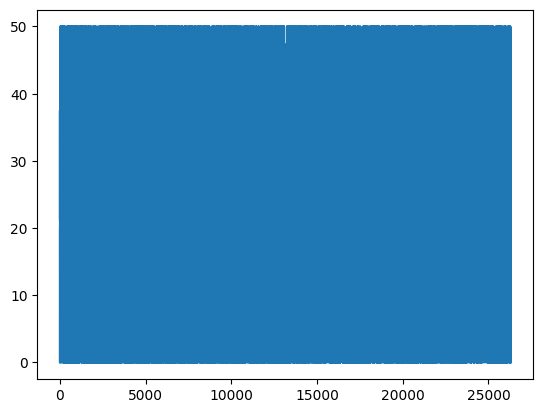

In [34]:
env = StorageEnv("../../train.xlsx")

total_cost = 0.0
action_range = [-1,1] # this can also be discrete now! e.g. action_repr = [-2,-1,0,1,2]
battery_charges = []

for episode in range(1):
    # current_day_prices = prices.iloc[episode].tolist()
    # env.reset() # fix the reset function and uncomment when running >1 episodes
    battery_level, hour = env.state
    done=False

    while not done:
      action = random.uniform(action_range[0], action_range[1]) # random value between -1 and 1
      # print(env.counter) # counter goes until 26302 = 25208 + 1096, not sure why
      state, reward, done, truncated, info = env.step(action) # get the new state
      battery_level, hour = state

      battery_charges.append(battery_level)

      total_cost += reward

    # finished, all hours*days have been seen
    print(f"At episode {episode+1}, total electricity expenditure is: {total_cost}")

# restrict actions for selling

plt.plot(battery_charges)

In [35]:
battery_charges

[21.434161147736646,
 37.49211342633021,
 17.887874018743453,
 0.0,
 0.0,
 11.609587916529495,
 20.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 19.768101011523992,
 0.0,
 4.957704870549707,
 25.58122581270709,
 14.660606920997251,
 3.389835478834055,
 9.25309748202893,
 17.329367489421134,
 14.120510767609447,
 13.930288741620291,
 31.360559024113883,
 42.82987800783758,
 42.181686779265995,
 50,
 50,
 43.29988402703024,
 50,
 47.81542525159212,
 26.07543545625011,
 39.09764658930812,
 50,
 50,
 50,
 36.55792067484059,
 50,
 48.25036252150678,
 47.257628200071196,
 29.87077942564569,
 37.819328854462285,
 13.655404626415578,
 26.47543988586554,
 42.340096629710075,
 22.33497146275485,
 43.80563091437136,
 50,
 50,
 27.580030616963054,
 42.93613063871766,
 50,
 28.1258459226548,
 50,
 36.79837473416681,
 14.697448391873273,
 17.693128291810304,
 30.62411881945686,
 50,
 43.57255285643162,
 19.721803900323355,
 16.19398626301541,
 36.56237101003812,
 11.977

In [ ]:
### OLD

# 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# 2 take at_home out of the state *
# 3 include the action mechanics inside of the step function *
# 4 test environment again on random policy loop *
# 5 try q learning
# 6 change action to -1, 1 range
# 7 change reward calculation *
# 8 test with the test environment (validate using main.py)
# 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# 10 change hour from 08-07 to 01-00

class StorageEnv(Env):
    def __init__(self, path_to_train_data):
        '''
        Initialization of the energy storage environment;
        We interpret a run through all historical price data as one trajectory = one episode,
        where for each hour of each day, we can run the step function to update from one state
        to the next, given some action for that hour (the step function will return the next
        state, as well as next reward, and whether the entire historical dataset has been
        iterated through using the 'done' variable in the return statement).
        '''

        self.train_data = pd.read_excel(path_to_train_data)
        self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.train_data['PRICES']
        self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx

        self.values_actions =  [-20, -10, 0, 10, 20]
        self.batteries =  [0, 10, 20, 30, 40, 50]
        self.action_repr = [-2,-1,0,1,2]

        self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument

        self.action_space = Discrete(5, start=-2)
        self.battery_space = Discrete(6, start=0)
        self.position_space = Discrete(2, start=0)

        self.counter = 0
        self.hour = 1
        self.day = 1
        self.num_hours_day = 24

        self.min_battery_level_start = 2
        self.min_battery_level = 0
        self.max_battery_level = 5

        # battery level from 0 to 50 (10 incr.), indication car at home or not
        self.observation_space = MultiDiscrete([self.battery_space.n,
                                                self.position_space.n,
                                                self.num_hours_day])

        # initialize state vars
        self.battery_level = np.random.randint(self.min_battery_level_start, self.max_battery_level)
        # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
        self.at_home = np.random.randint(self.position_space.n) # dont need this anymore or?
        # initial state
        self.state = [self.battery_level, self.hour]


    def step(self, action):
        ######### at current timestep t
        ### battery comsumption at timestep t

        # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
        if not self.at_home: # check if car is currently away, enforced by overriding previous if statement
          action = 0

        # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
        elif self.at_home:
          # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
          if self.hour == 7:
            legal_actions = get_legal_actions_at_last(self.action_repr, self.battery_level)
            if action not in legal_actions: # check if action chosen by agent ensures 20kwh of battery at 7am
              action = min(legal_actions)
          # rest of the day, ensure that battery stays above 0kwh
          else:
            legal_actions = get_legal_actions(self.action_repr, self.battery_level)
            if action not in legal_actions:
              action = min(legal_actions)

        # removing 20kwh from battery when going away from home
        if not self.at_home:
          self.battery_level = self.battery_level-2 if self.hour == 0 else self.battery_level

        # update battery level based on the picked acion at timestep t
        if self.at_home:
            self.battery_level += action

        # no over-charging above 50kwh
        if self.battery_level >= 5:
            self.battery_level = 5

        # should we move the constraints not lower 0 here ??

        ######### update the state for next hour, timestep t+1
        # keep the hour 8 ~ 18 same, otherwise athome = True
        self.at_home = self.at_home if self.hour < 18 else 1

        # reward calculations
        hourly_price = self.price_values[self.day-1][self.hour-1]
        cost_factor = 1.0 if action < 0 else 2.0
        efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

        # get amount of kwh bought during this step
        kwhs_charged = action * 10 # change this 10 when changing action space!!!
        price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
        # add reward here, based on price from table

        reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

        # update counter and time variables
        self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
        self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

        if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
            self.hour = 1 # reset hour of the day for next timestep
            self.day += 1 # increment to start of next day

        # update state
        self.state = [self.battery_level, self.hour]

        # check if all hours in the dataset have been seen
        self.done = self.counter+1 == self.nr_hours

        truncated = False
        info = {}

        return self.state, reward, self.done, truncated, info

    def render(self):
        pass

    def reset(self):
      # initialize battery level randomly between 0 and 6, representing the space 0-50kwh
      self.battery_level = np.random.randint(self.min_battery_level_start, self.max_battery_level)
      # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
      self.at_home = np.random.randint(self.position_space.n)
      # hour may not need to be in the state..?
      self.hour = 1
      self.done = False
       # initial state
      self.state = [self.battery_level, self.hour]

      return self.state



In [ ]:
env = StorageEnv()

actions = env.action_space
observations = env.observation_space
actions.sample, observations



(<bound method Discrete.sample of Discrete(5, start=-2)>,
 MultiDiscrete([ 6  2 24]))

In [ ]:
episodes = len(prices)

total_cost = 0.0
min_level = 2
all_actions = np.array([-2,-1,0,1,2])
battery_charges=[]
for episode in range(episodes):
    current_day_prices = prices.iloc[episode].tolist()
    env.reset()
    battery_level, at_home, hour = env.state
    daily_cost = 0.0

    while not env.done:
    # for h in range(24):
      current_hourly_price = current_day_prices[hour] /1000.0 # get old hourly price
      # env.render()
      #

      if not at_home: # check if car is currently away, enforced by overriding previous if statement
          action = random.choice([0])
          # print("action 5", action)

      if at_home:
        if hour == 23:
          legal_actions = get_legal_actions_at_last(all_actions, battery_level)
          action = random.choice(legal_actions)
        else:
          legal_actions = get_legal_actions(all_actions, battery_level)
          action = random.choice(legal_actions)


      state, kwhs_charged, done, info = env.step(action) # get the new state
      battery_level, at_home, hour = state

      # print("current_hourly_price", current_hourly_price)
      # print("reward: ", reward)
      factor = 1.0 if action < 0 else 2.0
      # if hour == 24  and battery_level <2:
      #   print(f"{episode} -  {hour} - {battery_level} - {env.done}")
      reward = (-1) * kwhs_charged * current_hourly_price * factor # add electricity price
      battery_charges.append(battery_level)
      # reward = kwhs_charged
      daily_cost += reward
      # print("type daily: ", type(daily_cost))
      # print("daily: ", daily_cost)
    # finished, t=24
    total_cost += daily_cost
    # print("total:", total_cost)
    # print("type total: ", type(total_cost))

    # done = False

    print(f"At episode {episode+1}, total electricity expenditure is: {daily_cost}")
# restrict actions for seling
# restrict selling at hour 23 to only >20

At episode 1, total electricity expenditure is: -4.8809000000000005
At episode 2, total electricity expenditure is: -8.1278
At episode 3, total electricity expenditure is: -3.4595
At episode 4, total electricity expenditure is: -5.551100000000001
At episode 5, total electricity expenditure is: -3.0806
At episode 6, total electricity expenditure is: -7.238299999999999
At episode 7, total electricity expenditure is: -2.452
At episode 8, total electricity expenditure is: -6.716
At episode 9, total electricity expenditure is: -3.2681
At episode 10, total electricity expenditure is: -3.2055
At episode 11, total electricity expenditure is: -4.0282
At episode 12, total electricity expenditure is: -4.2286
At episode 13, total electricity expenditure is: -3.5252999999999997
At episode 14, total electricity expenditure is: -6.993900000000001
At episode 15, total electricity expenditure is: -5.768700000000001
At episode 16, total electricity expenditure is: -10.983799999999999
At episode 17, tota

In [ ]:
print(total_cost)

-9126.421100000001


In [ ]:
class QAgent():

    def __init__(self, env_name, discount_rate = 0.95, bin_size = 20):

        '''
        Params:

        env_name = name of the specific environment that the agent wants to solve
        discount_rate = discount rate used for future rewards
        bin_size = number of bins used for discretizing the state space

        '''

        #create an environment
        self.env_name = env_name
        self.env = gym.make(env_name)

        #Set the discount rate
        self.discount_rate = discount_rate

        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        #self.action_space = range(self.env.action_space.n)

        self.action_space = self.env.action_space.n

        #Set the bin size
        self.bin_size = bin_size

        #State incorporates the observation state
        #State[0] is x position
        #State[1] is velocity

        #Get the low and high values of the environment space
        self.low = self.env.observation_space.low
        self.high = self.env.observation_space.high

        #Create bins for both observation features, i.e. x-position and velocity

        self.bin_x = np.linspace(self.low[0], self.high[0], self.bin_size)

        '''
        ToDo:

        Please create the bins for the velocity feature in the same manner and call this variable self.bin_velocity!
        '''

        self.bin_velocity = np.linspace(self.low[1], self.high[1], self.bin_size)


        #Put the two bins together
        self.bins = [self.bin_x, self.bin_velocity]

    def discretize_state(self, state):

        '''
        Params:
        state = state observation that needs to be discretized


        Returns:
        discretized state
        '''
        #Now we can make use of the function np.digitize and bin it
        self.state = state

        #Create an empty state
        digitized_state = []

        for i in range(len(self.bins)):
            digitized_state.append(np.digitize(self.state[i], self.bins[i])-1)

        #Returns the discretized state from an observation
        return digitized_state

    def create_Q_table(self):
        self.state_space = self.bin_size - 1
        #Initialize all values in the Q-table to zero
        #Matrix of dimension state_space * state_space * action_space with zero entries

        '''
        ToDo:
        Initialize a zero matrix of dimension state_space * state_space * action_space and call it self.Qtable!
        '''

        self.Qtable = np.zeros((self.bin_size,self.bin_size,self.action_space))

    def train(self, simulations, learning_rate, epsilon = 0.05, epsilon_decay = 1000, adaptive_epsilon = False,
              adapting_learning_rate = False):

        '''
        Params:

        simulations = number of episodes of a game to run
        learning_rate = learning rate for the update equation
        epsilon = epsilon value for epsilon-greedy algorithm
        epsilon_decay = number of full episodes (games) over which the epsilon value will decay to its final value
        adaptive_epsilon = boolean that indicates if the epsilon rate will decay over time or not
        adapting_learning_rate = boolean that indicates if the learning rate should be adaptive or not

        '''

        #Initialize variables that keep track of the rewards

        self.rewards = []
        self.average_rewards = []

        #Call the Q table function to create an initialized Q table
        self.create_Q_table()

        #Set epsilon rate, epsilon decay and learning rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        #Set start epsilon, so here we want a starting exploration rate of 1
        self.epsilon_start = 1
        self.epsilon_end = 0.05

        #If we choose adaptive learning rate, we start with a value of 1 and decay it over time!
        if adapting_learning_rate:
            self.learning_rate = 1

        for i in range(simulations):

            if i % 5000 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            #Initialize the state
            state = self.env.reset()[0] # reset returns a dict, need to take the 0th entry

            #Set a variable that flags if an episode has terminated
            done = False

            #Discretize the state space

            state = self.discretize_state(state)

            #Set the rewards to 0
            total_rewards = 0

            #If adaptive epsilon rate
            if adaptive_epsilon:
                self.epsilon = np.interp(i, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])

                #Logging just to check it decays as we want it to do, we just print out the first three statements
                if i % 500 == 0 and i <= 1500:
                    print(f"The current epsilon rate is {self.epsilon}")

            #Loop until an episode has terminated
            while not done:

                #Pick an action based on epsilon greedy

                '''
                ToDo: Write the if statement that picks a random action
                Tip: Make use of np.random.uniform() and the self.epsilon to make a decision!
                Tip: You can also make use of the method sample() of the self.env.action_space
                    to generate a random action!
                '''

                #Pick random action

                if np.random.uniform(0,1) <= self.epsilon:
                    action = np.random.randint(0,self.action_space)

                #Pick a greedy action

                else:
                    action = np.argmax(self.Qtable[state[0], state[1], :])

                #Now sample the next_state, reward, done and info from the environment

                next_state, reward, terminated, truncated, info = self.env.step(action) # step returns 5 outputs
                done = terminated or truncated

                #Now discretize the next_state
                next_state = self.discretize_state(next_state)

                #Target value
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], next_state[1]]))

                #Calculate the Temporal difference error (delta)
                '''
                ToDo: Calculate the Temporal difference error (delta)
                Tip: Make use of slide 17 from the Q-learning slides on Canvas
                '''

                delta = self.learning_rate * (Q_target - self.Qtable[state[0], state[1], action])

                #Update the Q-value
                self.Qtable[state[0], state[1], action] = self.Qtable[state[0], state[1], action] + delta

                #Update the reward and the hyperparameters
                total_rewards += reward
                state = next_state

            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i+1)

            self.rewards.append(total_rewards)

            #Calculate the average score over 100 episodes
            if i % 100 == 0:
                self.average_rewards.append(np.mean(self.rewards))

                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []

        print('The simulation is done!')

    def visualize_rewards(self):
        plt.figure(figsize =(7.5,7.5))
        plt.plot(100*(np.arange(len(self.average_rewards))+1), self.average_rewards)
        plt.axhline(y = -110, color = 'r', linestyle = '-')
        plt.title('Average reward over the past 100 simulations', fontsize = 10)
        plt.legend(['Q-learning performance','Benchmark'])
        plt.xlabel('Number of simulations', fontsize = 10)
        plt.ylabel('Average reward', fontsize = 10)

    def play_game(self):
        # Make eval env which renders when taking a step
        eval_env = gym.make(env_name, render_mode='human')
        state = eval_env.reset()[0]
        done=False
        # Run the environment for 1 episode
        while not done:
            state = self.discretize_state(state)
            action = np.argmax(self.Qtable[state[0],state[1],:])
            next_state, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            state = next_state
        eval_env.close()

In [ ]:

class TestEnv(Env):
    def __init__(self):
        self.action_space = Discrete(3) # 3 actions, go down, stay, go up

        self.observation_space = Box(low=np.array([0]), high=np.array([100])) # temperature range, 0 to 100
        self.state = 38 + random.randint(-3,3) # initial temperature fluctuation
        self.shower_length = 60 # 60 steps/seconds
    def step(self, action):
        self.state += action-1 # controlling how the action influences the state (here, temp movement on the temperature)
        self.shower_length -= 1

        done = False

        if self.state>=37 and self.state <=39:
            reward = 1
        else:
            reward = -1

        if self.shower_length <= 0:
            done = True

        self.state += random.randint(-1,1) # add random flucuations in each step

        info = {}

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        self.state = 38 + random.randint(-3,3)
        self.shower_length = 60

        return self.state # return initial observation (=initial state)



In [ ]:
env = TestEnv()

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
env.observation_space.sample()

array([83.77458], dtype=float32)

In [ ]:
n_actions = 5
def get_action_space(n_actions):
  span = 50.0 / (n_actions - 1)
  actions = [ span * i - 25.0 for i in range(n_actions) ]
  print(f"actions: {actions}")
  return actions

action_space = get_action_space(n_actions=n_actions)

actions: [-25.0, -12.5, 0.0, 12.5, 25.0]


In [ ]:
# Read the CSV file to get the samples
df_train_data = pd.read_csv("train_transformed.csv")
train_data = df_train_data.drop(columns=['PRICES'])
train_data.columns = [i for i in range(24)]
train_data = train_data.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'train_transformed.csv'

In [ ]:


class TestEnv(Env):
    def __init__(self):
        self.action_space = Discrete(n_actions) # 5 actions, go down, stay, go up
        self.observation_space = Box(low=np.array([0]), high=np.array([50])) # temperature range, 0 to 100
        self.length = 24

        self.sample = train_data.sample()

        self.current_battery_level = np.random.randint(20, 50, size=1)[0]
        self.time = 0 # at the 8:00 - 9:00
        self.athome_hourly_space = np.zeros(24) # at home or not at this time
        for i in self.athome_hourly_space:
          if i >= 10:   # it is the index of the column (so 10 is 18 - 8)
            self.athome_hourly_space[i] = 1  # at home
        else:
          self.athome_hourly_space[i] = 0  # make it simple now (without account for the random choice)

        self.electric_price = self.sample[self.time]

        # might need to normalize *******
        self.state = [self.current_battery_level, self.electric_price, self.time, self.athome_hourly_space[self.time]]


    def step(self, action):
        # current_battery_level = action # require mapping from volume to action
        # check if it is night
        self.time += 1
        if self.time >= 10:
          self.athome = 1
        else:
          self.athome = 0

        electric_price = self.sample[self.time]  # get from data

        # check if >=50, and pick the action which is not large than 50 after summing up
        # if current_volume < 50:
        #   temp_action_space = copy.deepcopy(action_space)
        #   temp_action_space_1 = temp_action_space + current_volume - 50
        #   temp = temp_action_space_1[temp_action_space_1 >= 0]
        #   action = np.random.choice(temp, 1) + 20 - current_volume

        if self.athome == 1:
          current_battery_level += action_space[action] * 0.9
        else:
          current_battery_level -= current_battery_level - 2

        self.state = [current_battery_level, electric_price, time, self.athome_hourly_space[self.time]]



        # self.state += action-1 # controlling how the action influences the state (here, temp movement on the temperature)
        # self.state = [current_battery_level, electric_price, time, athome_hourly_space]
        # self.shower_length -= 1

        done = False

        if self.athome_hourly_space[self.time] == 1:
          if action > 0 :
            reward = -1 * action_space[action] * self.sample[self.time]
          else:
            reward = -1 * action_space[action] * self.sample[self.time] * 0.9
        else:
            reward = 0


        if self.time == 23:  # 7-8
        #     if current_volume < 20:
        #       temp_action_space = copy.deepcopy(action_space)
        #       temp_action_space_1 = temp_action_space + current_volume - 20
        #       temp = temp_action_space_1[temp_action_space_1 >= 0]
        #       action = np.random.choice(temp, 1) + 20 - current_volume

          done = True

        # self.state += random.randint(-1,1) # add random flucuations in each step

        info = {}

        return self.state, reward, done, info

    def render(self):
        pass
    def reset(self):
        self.sample = train_data.sample()
        current_battery_level = np.random.randint(20, 50, size=1)[0]
        self.time = 0 # at the 8:00
        self.athome_hourly_space = np.zeros(24) # at home or not at this time
        for i in self.athome_hourly_space:
          if i >= 10:   # it is the index of the column (so 10 is 18 - 8)
            self.athome_hourly_space[i] = 1  # at home
        else:
          self.athome_hourly_space[i] = 0  # make it simple now (without account for the random choice)

        self.state = [current_battery_level, self.sample[self.time], self.time, self.athome_hourly_space[self.time]]

        self.length = 24

        return self.state # return initial observation (=initial state)

In [ ]:
episodes = 50
for episode in range(1, episodes):
    state = env.reset() # initial state
    done = False
    score = 0


    for hour, _ in enumerate(episode):


        action = env.action_space.sample() # sample random action
        new_state, reward, done, info = env.step(action)
        score += reward
    print(f"Episode {episode} has a total reward over 60 steps of: {score}")



In [ ]:
os.chdir("../../Project")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('AAPL.csv', sep=',', header=0)
# cols = pd.read_csv('AAPL.csv', nrows=1).columns
# df = pd.read_csv('AAPL.csv',sep=',"', usecols=cols)

df = df[["Date","Price", "Vol."]]#.iloc[:, [0, 4, 28, -2]]
df['Date'] = pd.to_datetime(df['Date'])
df["Vol."] = df["Vol."].apply(lambda x:float(x[:-1]))

df = df.sort_values(by=["Date"],ascending=True)
df = df.set_index('Date', drop=False)
df = df.rename(columns={"Vol.":"Vol"})

# for col in ['CAD', 'NZD', 'USD']:
#     df = df[df[col] != '-']
#     df[col] = pd.to_numeric(df[col])

# df = df[df['Date'] >= '2022-12-01'].reset_index(drop=True)
# print(df.head(3))
# print(f'\nThe date range: {df.Date.min()}/{ df.Date.max()}')

# plt.plot(df.index, [df['Price'], df["Vol"]])

plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = df.Price.plot(color='blue', grid=True, label='Price')
ax2 = df.Vol.plot(color='red', grid=True, secondary_y=True, label='Volume')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()


In [ ]:
s = np.random.normal(0, 0.1, 365)
s = np.sort(s)
plt.plot(s)

In [ ]:
df[df["Date"]>]

In [ ]:
plt.plot(year_df["Price"])


In [ ]:
for i in df["Date"].dt.date:
    print(i)

In [ ]:
df["Date"].dt.year

In [ ]:
import datetime

year_range = range(2002,2025)

for year in year_range:
    year_half = datetime.date(year, 7, 1)
    year_df = df[df["Date"].dt.year == year]
    print(year_df)

    first_half_year_df = year_df[year_df["Date"].dt.date < year_half]
    second_half_year_df = year_df[year_df["Date"].dt.date <= year_half]

    #old
    year_length = len(year_df)
    year_mean = np.mean(year_df["Price"])
    year_variance = 0.2*year_mean

    year_gaussian_signal = np.random.normal(year_mean, year_variance, year_length)
    year_gaussian_signal = np.sort(year_gaussian_signal)
    # plt.plot(year_df["Price"]+year_gaussian_signal)

    #end old

    first_half_year_df["Price"] = first_half_year_df["Price"]*1.75
    second_half_year_df["Price"] = second_half_year_df["Price"]*0.5

    # add noise to first half of the current year
    df.loc[df["Date"].dt.year == 2003 and df["Date"].dt.date < year_half, "Price"] = first_half_year_df["Price"] #df["Date"].dt.year == 2003 +
    # add noise to second half of the current year
    df.loc[df["Date"].dt.year == 2003 and df["Date"].dt.date >= year_half, "Price"] = second_half_year_df["Price"]

    # i=0
    # for day in yearly_df["Date"].dt.date:
    #     if day < year_half:
    #         i+=1
    # print(i)



In [ ]:
yearly_df

In [ ]:
from datetime import timedelta
from mockseries.trend import LinearTrend
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
trend = LinearTrend(coefficient=2, time_unit=timedelta(days=4), flat_base=100)
seasonality = \
SinusoidalSeasonality(amplitude=20, period=timedelta(days=7)) \
+ SinusoidalSeasonality(amplitude=4, period=timedelta(days=1))
noise = RedNoise(mean=0, std=3, correlation=0.5)
timeseries = trend + seasonality + noise

seasonality.preview_week()
timeseries.preview_month()

In [ ]:
np.mean(year_df["Price"])

In [ ]:
datetime.date(year, 7, 1) > datetime.date(year, 7, 2)

In [ ]:
import datetime as dt
year_range = range(1925,2025)

for year in year_range:
    yearly_df = df[df["Date"].dt.year == year]
    year_half = datetime.date(year, 7, 1)
    print(year_half)
    i=0
    for day in yearly_df["Date"].dt.date:
        if day < year_half:
            i+=1
    print(i)


In [ ]:
from datetime import date, timedelta


sdate = date(2019,3,22)   # start date
edate = date(2019,4,9)
pd.date_range(sdate,edate-timedelta(days=1),freq='d')
